**NOTE**: data selection process occurs in the `fig1-pose-manifold-classifier` processing notebook; just loading the data here

In [154]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from cuml.decomposition import PCA
# from sklearn.decomposition import PCA
from toolz import valmap, compose
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
from cuml.preprocessing import StandardScaler, LabelEncoder
# from sklearn.preprocessing import StandardScaler
from cuml.pipeline import make_pipeline
# from sklearn.pipeline import make_pipeline
# from cuml.model_selection import StratifiedKFold
# from sklearn.model_selection import cross_val_predict, RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.model_selection import (
    cross_val_score,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_predict,
    GridSearchCV, RandomizedSearchCV
)
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend
from sklearn.metrics import confusion_matrix

In [2]:
c = PlotConfig()
format_plots()
saver = save_factory(c.save_path / "network-optim", tight_layout=False)

In [3]:
version = 7  # arhmm version
tmp = joblib.load(f'/n/scratch3/users/w/wg41/aging-aligned-frames_version{version:02d}.p')
# tmp = joblib.load('/n/scratch3/users/w/wg41/aging-aligned-frames-pose-resampled.p')
all_frames = tmp['frames']
all_recon_frames = tmp['recon']

In [5]:
def flatten(x):
    return x.reshape(len(x), -1)


def multi_stage_pca(data, subset_frames=200, total_frames=7000, seed=0):
    np.random.seed(seed)

    train = []
    for k, v in data.items():
        train.append(v[np.random.permutation(np.arange(len(v)))[:subset_frames]])
    train = np.concatenate(train, axis=0)

    pca = PCA(n_components=10).fit(train.reshape(len(train), -1).astype('float32'))
    pcs = valmap(
        compose(
            pca.transform,
            flatten,
            lambda v: v[np.random.permutation(np.arange(len(v)))[:total_frames]].astype('float32'),
        ),
        data,
    )
    return pcs

In [7]:
example = flatten(list(all_frames.values())[0][:1000]).astype('float32')
out = PCA(n_components=10).fit_transform(example)

## Decode age from frame

In [81]:
# pipeline = make_pipeline(
#     StandardScaler(),
#     # LogisticRegression(max_iter=200, class_weight='balanced'),
#     LogisticRegression(max_iter=200, class_weight='balanced', linesearch_max_iter=5000, penalty='elasticnet', l1_ratio=0.9),
# )

In [144]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=2, max_iter=500, class_weight="balanced", penalty="elasticnet", l1_ratio=1e-3, linesearch_max_iter=5000
    ),
)

In [155]:
pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=200, max_depth=16)
)

### Transformed

In [145]:
frames_per_sample = 2_000

In [146]:
pcs = multi_stage_pca(
    all_recon_frames, total_frames=frames_per_sample, subset_frames=500
)

In [147]:
x = np.concatenate(list(pcs.values()), axis=0)
ages = np.concatenate([[k[-1]] * len(v) for k, v in pcs.items()])

In [148]:
y = LabelEncoder().fit_transform(ages).to_numpy()

In [156]:
trans_out = cross_val_score(
    pipeline,
    x,
    y,
    cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=0),
)
trans_out

array([0.24331607, 0.24313989, 0.24029015, 0.24195854])

In [150]:
col = np.unique(y)
add_cm = []
for i in range(10):
    lr_preds = cross_val_predict(
        pipeline,
        x,
        y,
        cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=i),
    )
    cm = confusion_matrix(y, lr_preds, labels=col)
    add_cm.append(cm)

[W] [17:21:04.848953] QWL-QN line search failed (code 1); stopping at the last valid step


In [151]:
avg_cm = np.mean(add_cm, axis=0)

In [152]:
cm_df = pd.DataFrame(avg_cm / avg_cm.sum(1, keepdims=True), columns=col, index=col)

[Text(0.5, 22.58333333333333, 'Predicted age (weeks)'),
 Text(36.458333333333336, 0.5, 'True age (weeks)')]

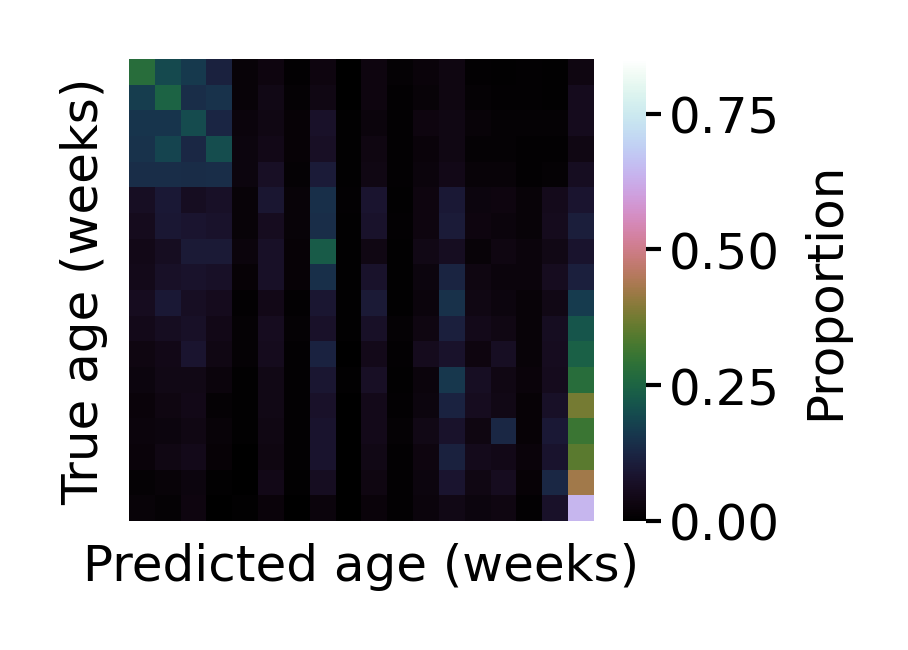

In [153]:
fig = figure(1.25, 1)
ax = sns.heatmap(
    cm_df,
    annot=False,
    cmap="cubehelix",
    cbar_kws=dict(label="Proportion"),
    vmax=0.85,
    vmin=0,
    xticklabels=False,
    yticklabels=False,
)
ax.set(xlabel='Predicted age (weeks)', ylabel='True age (weeks)')
# saver(fig, 'transformed-pose-age-classification-confusion-mtx');

In [100]:
np.random.seed(0)
shuff_trans_out = []
for i in tqdm(range(15)):
    shuff_trans_out.extend(cross_val_score(
        pipeline,
        x,
        np.random.permutation(y),
        cv=StratifiedKFold(6),
    ))
shuff_trans_out = np.array(shuff_trans_out)

  0%|          | 0/15 [00:00<?, ?it/s]

### Original

In [157]:
pcs = multi_stage_pca(
    all_frames, total_frames=frames_per_sample, subset_frames=500
)

In [158]:
x = np.concatenate(list(pcs.values()), axis=0)
ages = np.concatenate([[k[-1]] * len(v) for k, v in pcs.items()])

In [159]:
y = LabelEncoder().fit_transform(ages).to_numpy()

In [125]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=500, class_weight="balanced", penalty="elasticnet", l1_ratio=0.5, linesearch_max_iter=5000
    ),
)

In [134]:
gs = GridSearchCV(
    pipeline,
    dict(
        logisticregression__C=np.linspace(0.0001, 4, 15),
        logisticregression__l1_ratio=np.logspace(-4, 0, 11),
    ),
    cv=StratifiedKFold(3),
)

In [135]:
gs.fit(
    x,
    y=y,
)

[W] [17:15:29.276310] QWL-QN line search failed (code 1); stopping at the last valid step
[W] [17:15:29.707866] QWL-QN line search failed (code 1); stopping at the last valid step
[W] [17:15:30.446580] QWL-QN line search failed (code 1); stopping at the last valid step
[W] [17:15:31.350994] QWL-QN line search failed (code 1); stopping at the last valid step
[W] [17:15:31.881840] QWL-QN line search failed (code 1); stopping at the last valid step
[W] [17:15:32.722178] QWL-QN line search failed (code 1); stopping at the last valid step
[W] [17:15:32.835469] QWL-QN line search failed (code 1); stopping at the last valid step
[W] [17:15:32.952595] QWL-QN line search failed (code 1); stopping at the last valid step
[W] [17:15:33.849572] QWL-QN line search failed (code 1); stopping at the last valid step
[W] [17:15:35.549443] QWL-QN line search failed (code 1); stopping at the last valid step
[W] [17:15:46.583466] QWL-QN line search failed (code 1); stopping at the last valid step
[W] [17:15

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': array([1.00000000e-04, 2.85807143e-01, 5.71514286e-01, 8.57221429e-01,
       1.14292857e+00, 1.42863571e+00, 1.71434286e+00, 2.00005000e+00,
       2.28575714e+00, 2.57146429e+00, 2.85717143e+00, 3.14287857e+00,
       3.42858571e+00, 3.71429286e+00, 4.00000000e+00]),
                         'logisticregression__l1_ratio': array([1.00000000e-04, 2.51188643e-04, 6.30957344e-04, 1.58489319e-03,
       3.98107171e-03, 1.00000000e-02, 2.51188643e-02, 6.30957344e-02,
       1.58489319e-01, 3.98107171e-01, 1.00000000e+00])})

In [136]:
gs.best_params_

{'logisticregression__C': 2.00005,
 'logisticregression__l1_ratio': 0.001584893192461114}

In [137]:
gs.best_score_

0.25882387161254883

In [139]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=2, max_iter=500, class_weight="balanced", penalty="elasticnet", l1_ratio=1e-3, linesearch_max_iter=5000
    ),
)

In [160]:
raw_out = cross_val_score(
    pipeline,
    x,
    y,
    cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=0),
)
raw_out

array([0.38381347, 0.38726425, 0.38575131, 0.38334715])

In [141]:
lr_preds = cross_val_predict(
    pipeline,
    x,
    y,
    cv=StratifiedKFold(4),
)

[W] [17:20:07.863358] QWL-QN line search failed (code 1); stopping at the last valid step


In [142]:
col = np.unique(y)
cm = confusion_matrix(y, lr_preds, labels=col)

cm_df = pd.DataFrame(cm / cm.sum(1, keepdims=True), columns=col, index=col)

[Text(0.5, 22.58333333333333, 'Predicted age (weeks)'),
 Text(36.458333333333336, 0.5, 'True age (weeks)')]

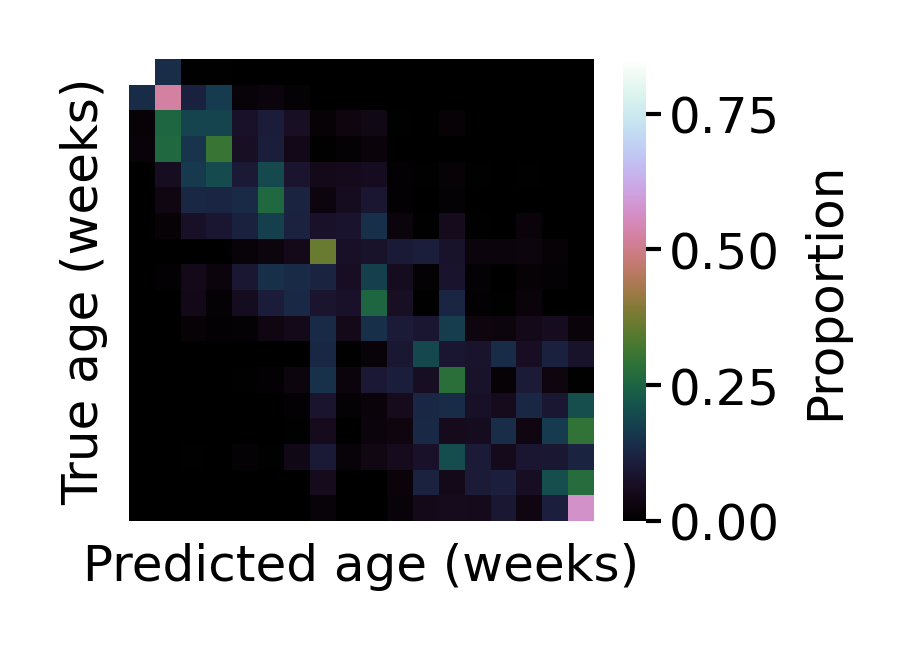

In [143]:
fig = figure(1.25, 1)
ax = sns.heatmap(
    cm_df,
    annot=False,
    cmap="cubehelix",
    cbar_kws=dict(label="Proportion"),
    vmax=0.85,
    vmin=0,
    xticklabels=False,
    yticklabels=False,
)
ax.set(xlabel="Predicted age (weeks)", ylabel="True age (weeks)")
# saver(fig, "raw-pose-age-classification-confusion-mtx");

In [121]:
np.random.seed(0)
shuff_raw_out = []
for i in tqdm(range(15)):
    shuff_raw_out.extend(cross_val_score(
        pipeline,
        x,
        np.random.permutation(y),
        cv=StratifiedKFold(4),
    ))
    # print(out)
shuff_raw_out = np.array(shuff_raw_out)

  0%|          | 0/15 [00:00<?, ?it/s]

### Accuracy comparison

In [122]:
outcomes = [
    pd.DataFrame(dict(acc=raw_out, treatment="Observed", type="Original")),
    pd.DataFrame(dict(acc=trans_out, treatment="Observed", type="Transformed")),
    pd.DataFrame(dict(acc=shuff_raw_out, treatment="Shuffle", type="Original")),
    pd.DataFrame(dict(acc=shuff_trans_out, treatment="Shuffle", type="Transformed")),
]
outcomes = pd.concat(outcomes, ignore_index=True)

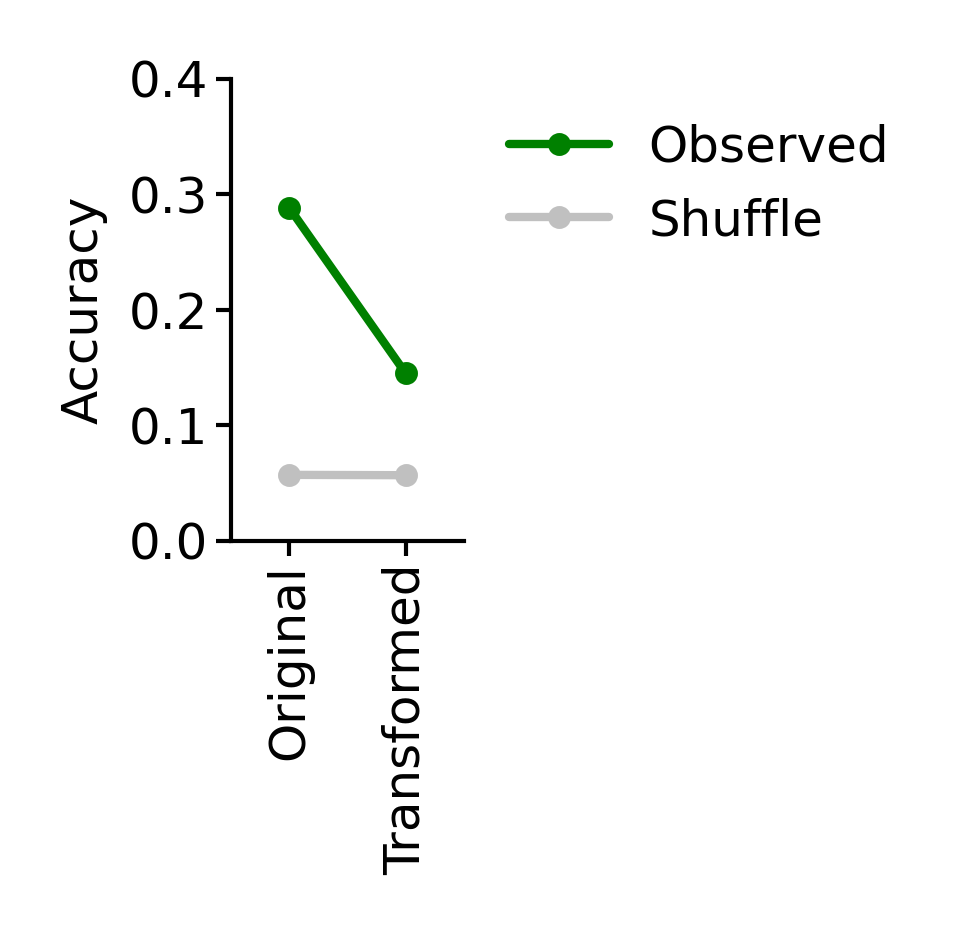

In [123]:
fig = figure(0.5, 1)
ax = sns.pointplot(
    data=outcomes,
    x="type",
    y="acc",
    palette=["green", "silver"],
    hue="treatment",
    hue_order=["Observed", "Shuffle"],
    errorbar=("sd", 2),
    markersize=2,
    linewidth=1,
)
ax.set(ylim=(0, 0.4), ylabel="Accuracy", xlabel="")
plt.xticks(rotation=90)
legend(ax)
sns.despine()
# saver(fig, "age-decoder-from-pose-pointplot");

## Decode age from frame PC dynamics